In [2]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets

In [3]:
class Flatten():
    def forward(self, x):
        self.x = x
        self.batch_size = x.shape[0]
        return x.reshape(self.batch_size, -1).T

    def backward(self, gradient):
        return gradient.T.reshape(self.x.shape)

In [4]:
class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * np.sqrt(2 / (in_size + 1))
        self.b = np.zeros((out_size, 1))
    
    def forward(self, x):
        self.x = x
        self.s = np.dot(np.transpose(self.W), self.x) + self.b
        return self.s

    def backward(self, gradient):
        self.dW = np.dot(self.x, np.transpose(gradient))
        self.db = np.sum(gradient, axis=1, keepdims=True)
        return np.dot(self.W, gradient)

In [5]:
class ReLU():
    def forward(self, s):
        self.s = s
        return np.maximum(0, s)
    
    def backward(self, gradient):
        return gradient * (self.s > 0).astype(float)

In [6]:
class Softmax():    
    def forward(self, s):
        e_s = np.exp(s - np.max(s, axis=0, keepdims=True))
        self.output = e_s / e_s.sum(axis=0, keepdims=True)
        return self.output
    
    def backward(self, gradient):
        return gradient

In [7]:
class CrossEntropyLoss():
    def forward(self, x_L, y):
        epsilon = 1e-12
        x_L = np.clip(x_L, epsilon, 1 - epsilon)
        self.x_L = x_L
        self.y = y
        self.N = x_L.shape[1]
        return -np.sum(y * np.log(x_L)) / self.N

    def backward(self):
        return (self.x_L - self.y) / self.N

In [8]:
class Optimizer:
    def update(self, dW, db, layer):
        raise NotImplementedError('Error')

In [9]:
class BasicOptimizer(Optimizer):
    def __init__(self, lr=1e-3):
        self.lr = lr

    def update(self, dW, db, layer):
        layer.W -= self.lr * dW
        layer.b -= self.lr * db

In [10]:
class MomentumOptimizer(Optimizer):
    def __init__(self, lr=1e-2, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.velocity = {}

    def update(self, dW, db, layer):
        if layer not in self.velocity:
            self.velocity[layer] = {"W": np.zeros_like(layer.W), "b": np.zeros_like(layer.b)}

        self.velocity[layer]["W"] = self.momentum * self.velocity[layer]["W"] - self.lr * dW
        self.velocity[layer]["b"] = self.momentum * self.velocity[layer]["b"] - self.lr * db

        layer.W += self.velocity[layer]["W"]
        layer.b += self.velocity[layer]["b"]

In [11]:
class AdamOptimizer():
    def __init__(self, lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0

    def update(self, dW, db, layer):
        if layer not in self.m:
            self.m[layer] = {"W": np.zeros_like(layer.W), "b": np.zeros_like(layer.b)}
            self.v[layer] = {"W": np.zeros_like(layer.W), "b": np.zeros_like(layer.b)}

        self.t += 1
        
        self.m[layer]["W"] = self.beta1 * self.m[layer]["W"] + (1 - self.beta1) * dW
        self.m[layer]["b"] = self.beta1 * self.m[layer]["b"] + (1 - self.beta1) * db
        
        self.v[layer]["W"] = self.beta2 * self.v[layer]["W"] + (1 - self.beta2) * (dW ** 2)
        self.v[layer]["b"] = self.beta2 * self.v[layer]["b"] + (1 - self.beta2) * (db ** 2)

        m_hat_W = self.m[layer]["W"] / (1 - self.beta1 ** self.t)
        m_hat_b = self.m[layer]["b"] / (1 - self.beta1 ** self.t)
        
        v_hat_W = self.v[layer]["W"] / (1 - self.beta2 ** self.t)
        v_hat_b = self.v[layer]["b"] / (1 - self.beta2 ** self.t)
        
        layer.W -= self.lr * (m_hat_W / (np.sqrt(v_hat_W) + self.epsilon))
        layer.b -= self.lr * (m_hat_b / (np.sqrt(v_hat_b) + self.epsilon))

In [12]:
class NN():
    def __init__(self):
        self.layers = []
    
    def add(self, layer):
        self.layers.append(layer)

    def sequential(self, *layers):
        self.layers.extend(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        
        return x
    
    def backward(self, loss_grad):
        gradients = []
        for layer in reversed(self.layers):
            if isinstance(layer, Linear):
                loss_grad = layer.backward(loss_grad)
                gradients.append((layer.dW, layer.db, layer))
            else:
                loss_grad = layer.backward(loss_grad)

        return gradients
    
    def update_weights(self, gradients, optimizer):
        for dW, db, layer in gradients:
            optimizer.update(dW, db, layer)
    
    def train(self, x, y, optimizer, loss_fn):
        output = self.forward(x)
        loss = loss_fn.forward(output, y)
        loss_grad = loss_fn.backward()
        gradients = self.backward(loss_grad)
        self.update_weights(gradients, optimizer)

        return loss

In [13]:
def getDataset():
    train_dataset = datasets.MNIST(root='./data', train=True, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True)

    x_train = train_dataset.data.numpy() / 255.0
    y_train = train_dataset.targets.numpy()

    x_test = test_dataset.data.numpy() / 255.0
    y_test = test_dataset.targets.numpy()

    return x_train, y_train, x_test, y_test

In [14]:
def testAccuracy(model, x_test, y_test, batch_size):
    corr = 0
    total = len(x_test)

    perm = np.random.permutation(total)
    x_test = x_test[perm]
    y_test = y_test[perm]

    for n in range(0, total, batch_size):
        x_batch = x_test[n: n + batch_size]
        y_batch = y_test[n: n + batch_size]
        
        preds = model.forward(x_batch)
        preds = np.argmax(preds, axis=0)

        corr += np.sum(preds == y_batch)

    print(f'Accuracy: {round(corr / total * 100, 2)}%')


In [15]:
def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot.T

In [16]:
def plotLoss(err):
    plt.plot(err, linewidth = 2.0)
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.show()

In [17]:
def train(model, x_train, y_train, epochs, batch_size, output_size, loss_fn, optimizer):
    N = x_train.shape[0]
    err = []

    for epoch in range(epochs):
        total_loss = 0
        perm = np.random.permutation(N)
        x_train = x_train[perm]
        y_train = y_train[perm]

        for n in range(0, N):
            x_batch = x_train[n: n + batch_size]
            y_batch = one_hot_encode(y_train[n: n + batch_size], output_size)

            loss = model.train(x_batch, y_batch, optimizer, loss_fn)

            total_loss += loss
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / N}")
        err.append(total_loss)

    return err

Epoch 1/10, Loss: 0.09719052817523968
Epoch 2/10, Loss: 0.034820538783565634
Epoch 3/10, Loss: 0.02340276478401961
Epoch 4/10, Loss: 0.016448090091709923
Epoch 5/10, Loss: 0.012406123854008968
Epoch 6/10, Loss: 0.009239929242177019
Epoch 7/10, Loss: 0.007463248409003233
Epoch 8/10, Loss: 0.005911469936650948
Epoch 9/10, Loss: 0.0041024604791015115
Epoch 10/10, Loss: 0.003664587886146685


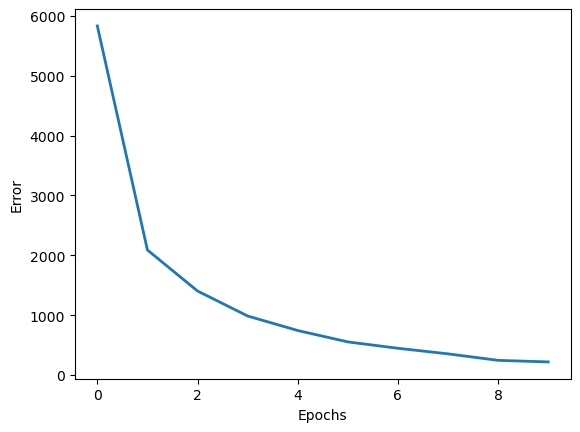

Accuracy: 97.66%


In [21]:
x_train, y_train, x_test, y_test = getDataset()

lr = 1e-2
epochs = 10
batch_size = 4

N = x_train.shape[0]
input_size = x_train.shape[1] * x_train.shape[2]
hidden_size1 = 128
hidden_size2 = 32
output_size = 10

loss_fn = CrossEntropyLoss()
optimizer = BasicOptimizer(lr=lr)

model = NN()
model.sequential(
    Flatten(),
    Linear(input_size, hidden_size1),
    ReLU(),
    Linear(hidden_size1, hidden_size2),
    ReLU(),
    Linear(hidden_size2, output_size),
    Softmax()
)

loss = train(model, x_train, y_train, epochs, batch_size, output_size, loss_fn, optimizer)
plotLoss(loss)
testAccuracy(model, x_test, y_test, batch_size)